In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency 
import scipy.stats as stats 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [161]:
actual_data = pd.read_excel("/Users/shreyarora/Downloads/IBM_CAO_Data_Science_Challenge_2022-2023.xlsx","Table1-SW Deals")

## Exploratory Data Analysis

In [162]:
data = actual_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478608 entries, 0 to 478607
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   PROD_CATEGORY   478608 non-null  object        
 1   WEB_QUOTE_NUM   478608 non-null  int64         
 2   CUSTOMER_NUM    478608 non-null  object        
 3   WON             478608 non-null  int64         
 4   CNTRY_CODE      478608 non-null  object        
 5   PART_NUM        478608 non-null  object        
 6   PART_QTY        478608 non-null  int64         
 7   QUOTE_PRICE     478608 non-null  float64       
 8   ENTITLED_PRICE  478608 non-null  float64       
 9   SUBMIT_DATE     478608 non-null  datetime64[ns]
 10  EXCHANGE_RATE   478608 non-null  float64       
 11  CURRNCY_CODE    478608 non-null  object        
 12  START_DATE      478608 non-null  datetime64[ns]
 13  END_DATE        478608 non-null  datetime64[ns]
 14  INDUSTRY_CODE   478608 non-null  obj

In [163]:
data.describe()

,WEB_QUOTE_NUM,WON,PART_QTY,QUOTE_PRICE,ENTITLED_PRICE,EXCHANGE_RATE,SUBMIT_YR
count,4.786080e+05,478608.000000,4.786080e+05,4.786080e+05,4.786080e+05,478608.00000,478608.000000
mean,1.668992e+08,0.519707,4.731914e+04,7.389219e+04,6.931678e+05,0.97557,2020.096398
std,3.668802e+08,0.499612,6.437065e+06,2.677050e+06,5.050222e+07,0.06883,0.986004
min,8.009760e+05,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.76746,2019.000000
25%,1.281187e+07,0.000000,1.000000e+00,1.200000e+03,1.833360e+03,1.00000,2019.000000
50%,1.581512e+07,1.000000,9.000000e+00,5.617700e+03,8.550000e+03,1.00000,2020.000000
75%,1.873137e+07,1.000000,1.500000e+02,2.414549e+04,4.025000e+04,1.00000,2021.000000
max,1.110033e+09,1.000000,1.000000e+09,5.846750e+08,1.882648e+10,1.00000,2022.000000


Chi square of association for categorical variables

In [165]:
continous_cols = ["PART_QTY","QUOTE_PRICE","ENTITLED_PRICE","EXCHANGE_RATE","SUBMIT_DATE","START_DATE","END_DATE","SUBMIT_YR"]

categorical_cols = ['PROD_CATEGORY', 'CUSTOMER_NUM', 'CNTRY_CODE',
       'PART_NUM', 'CURRNCY_CODE', 'INDUSTRY_CODE', 'INDUSTRY_DESC']


In [109]:
p_values = pd.DataFrame()

for c in categorical_cols:
        
    chisqt = pd.crosstab(data["WON"], data[c], margins=True)
    value = np.array([chisqt.iloc[0][0:len(set(data[c]))+2].values,
                      chisqt.iloc[1][0:len(set(data[c]))+2].values])
    c = chi2_contingency(value)[0:3]
    d = {"statistic":c[0],"p-value":c[1],"dof":c[2]}
    p_values = p_values.append(d,ignore_index=True)  

/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/596082589.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_values = p_values.append(d,ignore_index=True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/596082589.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_values = p_values.append(d,ignore_index=True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/596082589.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_values = p_values.append(d,ignore_index=True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/596082589.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [110]:
p_values["column"] = categorical_cols
p_values

,statistic,p-value,dof,column
0,7201.169242,0.000000,4.0,PROD_CATEGORY
1,214616.980976,0.000000,40051.0,CUSTOMER_NUM
2,0.046879,0.976833,2.0,CNTRY_CODE
3,54947.079384,0.000000,12847.0,PART_NUM
4,0.132611,0.935845,2.0,CURRNCY_CODE
5,15669.104299,0.000000,25.0,INDUSTRY_CODE
6,15669.104299,0.000000,25.0,INDUSTRY_DESC


ANOVA test for continuous variables

In [113]:
f_values,p_values = f_classif(data[["PART_QTY","QUOTE_PRICE","ENTITLED_PRICE","EXCHANGE_RATE"]], data["WON"])
anova = pd.DataFrame()
anova["columns"] = ["PART_QTY","QUOTE_PRICE","ENTITLED_PRICE","EXCHANGE_RATE"]
anova["Fvalue"] = f_values
anova["Pvalue"] = p_values
anova

,columns,Fvalue,Pvalue
0,PART_QTY,9.919329,1.635620e-03
1,QUOTE_PRICE,95.913494,1.206046e-22
2,ENTITLED_PRICE,7.312795,6.846776e-03
3,EXCHANGE_RATE,0.270425,6.030471e-01


CORRELATION HEAT MAP TO CHECK MULTICOLINEARITY AMONG FEATURES

<AxesSubplot:>

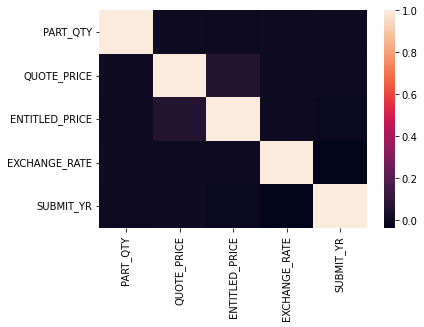

In [166]:
sns.heatmap(data[continous_cols].corr())

### Question 1.1

In [118]:
data_2021 = data[data["SUBMIT_YR"]==2021]
revenues = pd.DataFrame()
for n,g in data_2021.groupby("PROD_CATEGORY",0):
    revenues = revenues.append({"Product":n,"Revenue": g["QUOTE_PRICE"].sum()},ignore_index = True)


/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/2916698673.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  revenues = revenues.append({"Product":n,"Revenue": g["QUOTE_PRICE"].sum()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/2916698673.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  revenues = revenues.append({"Product":n,"Revenue": g["QUOTE_PRICE"].sum()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/2916698673.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  revenues = revenues.append({"Product":n,"Revenue": g["QUOTE_PRICE"].sum()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43

In [119]:
revenues

,Product,Revenue
0,SSW,9.661308e+08
1,SaaS,1.613708e+09
2,SnS Renew,5.279211e+09
3,Subscription,1.113450e+09


## Data Cleaning and Feature Engineering

Convert dates to timestamps

In [167]:
for c in ["SUBMIT_DATE","START_DATE","END_DATE"]:
    data[c] = pd.to_datetime(data[c])
    data[c]= data[c].map(dt.datetime.toordinal)

In [168]:
##Creating new feature
data["Duration"] = data["END_DATE"]-data["START_DATE"]


Create dummy variables for categorical date

In [169]:
encoded_data = pd.get_dummies(data, columns = ['PROD_CATEGORY', 'INDUSTRY_CODE',"CNTRY_CODE","CURRNCY_CODE"])

X = encoded_data.drop(columns = ["WON","WEB_QUOTE_NUM","CUSTOMER_NUM","INDUSTRY_DESC","PART_NUM","SUBMIT_YR","START_DATE","END_DATE"])
y = encoded_data["WON"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Random Forest Classifier for variable selection 

In [177]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [179]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['PART_QTY', 'QUOTE_PRICE', 'ENTITLED_PRICE', 'SUBMIT_DATE', 'Duration'], dtype='object')


'PART_QTY', 'QUOTE_PRICE', 'ENTITLED_PRICE', 'SUBMIT_DATE', 'Duration' are most significant drivers 

Logistic Regression on selected variables

In [202]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

log = LogisticRegression()
log.fit(X_train,y_train)

LogisticRegression()

In [203]:
print(confusion_matrix(y_test,log.predict(X_test)))

[[ 2713 43179]
 [ 1788 48042]]


In [204]:
accuracy_score(y_test,log.predict(X_test))

0.5302333841750068

Random Forest on selected variables

In [185]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train,y_train)

RandomForestClassifier()

In [186]:
print(confusion_matrix(y_test,rf.predict(X_test)))

[[32233 13659]
 [12811 37019]]


In [187]:
accuracy_score(y_test,rf.predict(X_test))

0.7234700486826435

XGBoost On selected Variables

In [190]:
xg = xgb.XGBClassifier(use_label_encoder=False)
xg.fit(X_train,y_train)

/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:29:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [191]:
print(confusion_matrix(y_test,xg.predict(X_test)))

[[26561 19331]
 [12382 37448]]


In [192]:
accuracy_score(y_test,xg.predict(X_test))

0.668696851298552

Competitor Data with Historical Data

In [205]:
compete_data = pd.read_excel("/Users/shreyarora/Downloads/IBM_CAO_Data_Science_Challenge_2022-2023.xlsx","Tabel2-SW Deals Comments")

In [261]:
data2 = actual_data.copy()
data2 = pd.merge(data2,compete_data, on=['WEB_QUOTE_NUM','WEB_QUOTE_NUM'],how = "left")

counts = pd.DataFrame()
for n,g in data2.groupby("PROD_CATEGORY",0):
    counts = counts.append({"Product":n,"Comp Count": g["WEB_QUOTE_NUM"].count()},ignore_index = True)

counts

/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/653816266.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append({"Product":n,"Comp Count": g["WEB_QUOTE_NUM"].count()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/653816266.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append({"Product":n,"Comp Count": g["WEB_QUOTE_NUM"].count()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipykernel_43861/653816266.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append({"Product":n,"Comp Count": g["WEB_QUOTE_NUM"].count()},ignore_index = True)
/var/folders/6b/qlcxg39s5r34xw0601nhyb4c0000gn/T/ipyker

,Product,Comp Count
0,SSW,50327
1,SaaS,99419
2,SnS Renew,323076
3,Subscription,5786


In [260]:
data2.head()

,WEB_QUOTE_NUM,CMMT_TYPE,COMMENT,ADD_DATE,MOD_DATE,PROD_CATEGORY,CUSTOMER_NUM,WON,CNTRY_CODE,PART_NUM,...,QUOTE_PRICE,ENTITLED_PRICE,SUBMIT_DATE,EXCHANGE_RATE,CURRNCY_CODE,START_DATE,END_DATE,INDUSTRY_CODE,SUBMIT_YR,INDUSTRY_DESC
0,14728298,COMP_NAME,HP - EMC,2020-08-12 21:57:08,2020-08-12 22:06:58,SnS Renew,7908426,0,CAN,EPM09LL,...,524169.895,2679382.72,2020-08-12 22:08:07,0.783,CAD,2023-10-01,2024-09-30,28,2020,Government
1,14728298,COMP_NAME,HP - EMC,2020-08-12 21:57:08,2020-08-12 22:06:58,SnS Renew,7908426,0,CAN,EPM09LL,...,550400.301,2679382.72,2020-08-12 22:08:07,0.783,CAD,2024-10-01,2025-09-30,28,2020,Government
2,12120101,COMP_NAME,Unkown,2020-04-13 09:25:11,2020-04-13 09:28:13,SSW,4142317,0,USA,DNR1CLL,...,3390.000,11300.00,2020-04-13 09:28:33,1.000,USD,2020-04-22,2021-04-30,1,2020,To Be Assigned
3,12120101,COMP_NAME,Unkown,2020-04-13 09:25:11,2020-04-13 09:28:13,SSW,4142317,0,USA,DDR15LL,...,117.500,235.00,2020-04-13 09:28:33,1.000,USD,2020-04-22,2021-04-21,1,2020,To Be Assigned
4,12120101,COMP_NAME,Unkown,2020-04-13 09:25:11,2020-04-13 09:28:13,SSW,4142317,0,USA,DDR14LL,...,492.000,984.00,2020-04-13 09:28:33,1.000,USD,2020-04-22,2021-04-21,1,2020,To Be Assigned


In [286]:
data3 = actual_data.copy()
data3 = pd.merge(data3,compete_data ,on=['WEB_QUOTE_NUM','WEB_QUOTE_NUM'],how="left")
data3.fillna(0,inplace = True)

def hascomp(row):
    r = row["COMMENT"]
    if r==0:
        return 0
    else:
        return 1


In [288]:
data3["HAS_COMMENT"] = data3.apply(lambda x:hascomp(x),axis=1)

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

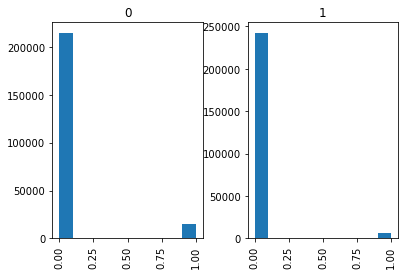

In [295]:
data3.hist(column = "HAS_COMMENT",by = "WON")